In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)


In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train_cls = load_cls(path+"X_train_cls.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_cls.p")

In [5]:
print(len(X_train_cls))

75000


In [6]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [7]:
from sklearn import svm

In [8]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'C': [0.001, 0.01, 0.1, 1,10],
     'gamma': [0.001, 0.01, 0.1, 1]
 }

In [9]:
gs_clf = GridSearchCV(svm.SVC(verbose=True,probability=True,cache_size=7000,max_iter=n_iter,gamma='auto',kernel='sigmoid'), 
                      parameters, cv=5, iid=True, n_jobs=-1, verbose=4)

In [10]:
model = gs_clf.fit(X_train_cls, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed: 70.7min
[Parallel(n_jobs=-1)]: Done  87 out of 100 | elapsed: 114.6min remaining: 17.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 117.5min finished


[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [11]:
model.best_score_

0.54004

In [12]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'C': 10, 'gamma': 0.001}
C: 10
gamma: 0.001


In [13]:
pickle.dump(model,open("SVM_CLS_Sigmoid_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [14]:
X_test_cls = load_cls(path+"X_test_cls.p")
y_test = load_cls(path+"y_test.p")

In [15]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = svm.SVC(verbose=True,
                        probability=True,
                        cache_size=7000,
                        max_iter=n_iter,
                        gamma=model.best_params_['gamma'],
                        kernel='sigmoid',
                        C=model.best_params_['C'])

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    #X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_cls[:eachTrain],y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    #X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_cls)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    #X_test_f = feature_pipeline.transform(X_test_cls)
    preds_test = bestModel.predict(X_test_cls)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_cls)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
[LibSVM]Train Time:0.06 sec
Validation Accuracy: 52.00%
Validation Time:1.63 sec
Test Accuracy: 51.59%
Test Time:1.60 sec
(0.3478693602693595, 0.11133333333333334, 0.39)
MRR: 0.3478693602693595
MRR Time:2.07 sec
SampleSize: 500
[LibSVM]Train Time:1.38 sec
Validation Accuracy: 56.29%
Validation Time:8.43 sec
Test Accuracy: 56.01%
Test Time:8.40 sec
(0.3143537758537752, 0.06733333333333333, 0.31066666666666665)
MRR: 0.3143537758537752
MRR Time:8.96 sec
SampleSize: 1000
[LibSVM]Train Time:5.37 sec
Validation Accuracy: 55.41%
Validation Time:15.94 sec
Test Accuracy: 55.69%
Test Time:15.94 sec
(0.29751168831168706, 0.048, 0.25)
MRR: 0.29751168831168706
MRR Time:16.35 sec
SampleSize: 10000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:142.38 sec
Validation Accuracy: 52.73%
Validation Time:31.53 sec
Test Accuracy: 53.61%
Test Time:31.64 sec
(0.44879672919672897, 0.19933333333333333, 0.568)
MRR: 0.44879672919672897
MRR Time:31.91 sec
SampleSize: 20000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:298.41 sec
Validation Accuracy: 52.75%
Validation Time:31.38 sec
Test Accuracy: 52.91%
Test Time:31.24 sec
(0.353607984607984, 0.09, 0.42133333333333334)
MRR: 0.353607984607984
MRR Time:31.70 sec
SampleSize: 50000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:730.19 sec
Validation Accuracy: 52.71%
Validation Time:31.71 sec
Test Accuracy: 52.99%
Test Time:31.64 sec
(0.35073294853294723, 0.09, 0.414)
MRR: 0.35073294853294723
MRR Time:32.10 sec
SampleSize: 75000
[LibSVM]

/home/kkpal/.conda/envs/msqa/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Train Time:1128.40 sec
Validation Accuracy: 52.98%
Validation Time:31.76 sec
Test Accuracy: 52.96%
Test Time:32.63 sec
(0.34911933621933483, 0.088, 0.408)
MRR: 0.34911933621933483
MRR Time:32.29 sec
[0.52, 0.5629, 0.5541, 0.5273, 0.5275, 0.5271, 0.5298]
[0.5159, 0.5601, 0.5569, 0.5361, 0.5291, 0.5299, 0.5296]
[0.3478693602693595, 0.3143537758537752, 0.29751168831168706, 0.44879672919672897, 0.353607984607984, 0.35073294853294723, 0.34911933621933483]
[0.11133333333333334, 0.06733333333333333, 0.048, 0.19933333333333333, 0.09, 0.09, 0.088]
[0.39, 0.31066666666666665, 0.25, 0.568, 0.42133333333333334, 0.414, 0.408]


In [18]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Cls_Sigmoid_Accuracy.png")
    #plt.show()

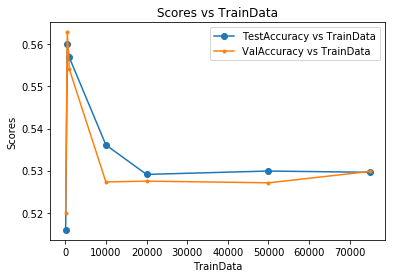

In [19]:
accuracyVisualization()

In [20]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("SVM_Cls_Sigmoid_Mrr.png")
    plt.show()

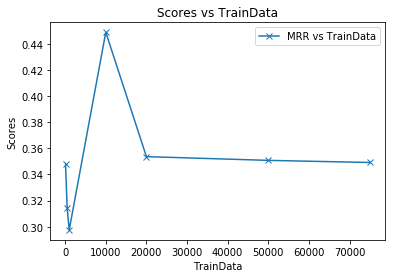

In [21]:
mrrVisualization()

In [22]:
def precisionVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='x')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='o')
    plt.title("Precisions vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Precisions")
    fig.savefig("SVM_Cls_Sigmoid_Precision.png")
    plt.show()

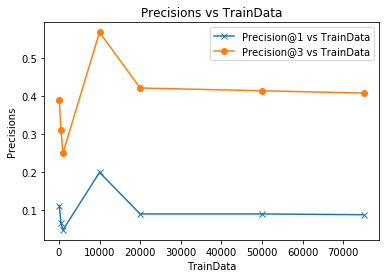

In [23]:
precisionVisualization()